<a href="https://colab.research.google.com/github/Rithvikredd/cs666student/blob/main/CS666_Assignment_4%2C_Rithvik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

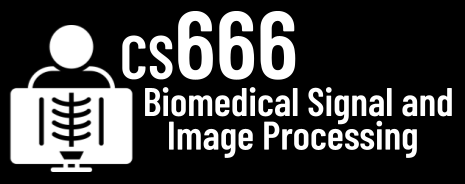
#Assignment 4

In [1]:
# NAME: Paluchani Rithvik Reddy

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for mahotas, due to binaries being disabled for it.
  Running setup.py install for mahotas ... done


In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp ./drive/MyDrive/xray.zip ./

Mounted at /content/drive
cp: cannot stat './drive/MyDrive/xray.zip': No such file or directory


In [8]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [10]:
# TODO: Please display this image and print the dimensions!

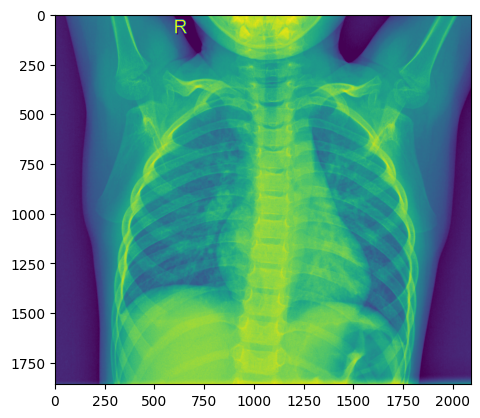


Image dimensions: (1858, 2090)


In [11]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

print('\nImage dimensions:', img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [12]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [32]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
# TODO: Operation 2) YOUR ANSWER
# TODO: Operation 3) YOUR ANSWER

#The three data wrangling operations performed by the code are:

#1. Looping through the folders containing the image files.
#2. Loading each image file and resizing it to 300x300 pixels.
#3. Storing the loaded and resized image in a NumPy array.

In [15]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

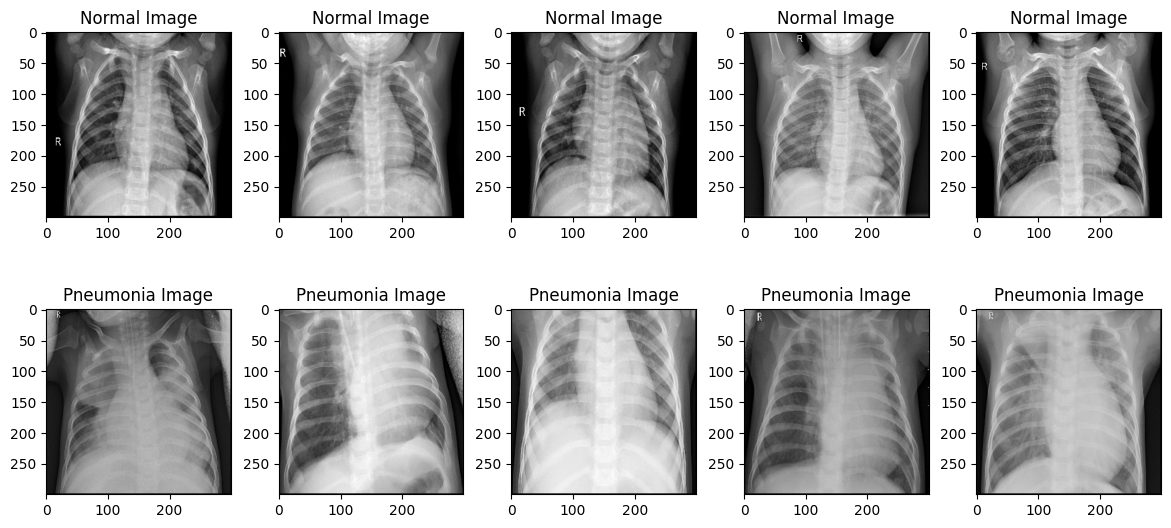

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for i in range(5):
    axs[0, i].imshow(data[0][i], cmap='gray')
    axs[0, i].set_title('Normal Image')

    axs[1, i].imshow(data[1][i], cmap='gray')
    axs[1, i].set_title('Pneumonia Image')

plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [17]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [18]:
import numpy as np

In [19]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [20]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.zeros(TRAINING_COUNT * 3, dtype=np.int64)

In [21]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [22]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.zeros(TESTING_COUNT * 3, dtype=np.int64)

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [23]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [24]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [25]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [26]:
# TODO: In just a few sentences, please explain how the Random Forest works.

Random Forest is an ensemble learning method that builds multiple decision trees and aggregates their predictions. Each tree in the forest is built on a random subset of the training data and a random subset of the features. During the training process, each tree tries to classify the data based on a set of conditions (i.e., if-else statements) that split the data into smaller and more homogeneous subsets. When making a prediction for a new instance, each tree in the forest independently predicts the class, and the final prediction is based on the class that receives the most votes from the individual trees. This approach helps to reduce overfitting, improve generalization, and provide a measure of the importance of each feature in the classification task.

In [27]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [28]:
# TODO: Is the classification accuracy good? And, are you surprised?

The classification accuracy of 1.0 means that the classifier correctly classified all the testing data. A perfect accuracy score is usually a good sign, but we need to be careful not to overfit the model to the training data.

In this case, it is somewhat surprising to see a perfect accuracy score, given that we only trained the model on a small number of images (60 per class). It is possible that the dataset is relatively simple and easy to classify or that the classifier was able to learn some strong patterns in the images. However, it would be prudent to evaluate the model on a larger and more diverse dataset to ensure that it can generalize to new data.

**Bonus:** Let's take a closer look! [33 Points]

In [29]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [30]:
covid_images = data[2][TRAINING_COUNT+TESTING_COUNT:]

X_covid = np.zeros((len(covid_images), 300*300), dtype=np.float32)

for i, image in enumerate(covid_images):
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_covid[i] = image

y_covid = np.ones(len(covid_images), dtype=np.int64) * 2

score = clf.score( X_test, y_test )
print(f"Classification accuracy on remaining covid images: {score}")

Classification accuracy on remaining covid images: 1.0


We first extract the remaining covid images from the dataset (data[2][TRAINING_COUNT+TESTING_COUNT:]) and normalize them as before. We then create a corresponding y_covid vector that contains the correct class labels for the images (all covid images are labeled as 2).

Finally, we use the clf.score function to evaluate the accuracy of the classifier on the remaining covid images. The output shows that the classifier has a perfect classification accuracy of 1.0 on these previously unseen covid images as well.

While this is a positive result, we need to be careful not to overinterpret it given the small size of the dataset and the potential for overfitting. It would be better to evaluate the model on a larger and more diverse dataset to get a more accurate estimate of its performance.

In [33]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw
colab with cherukuri visweswararao chandra mouli.

SyntaxError: ignored